In [30]:
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 34.0 MB 21.5 MB/s eta 0:00:01     |███████████████████████         | 24.4 MB 20.8 MB/s eta 0:00:01     |██████████████████████████▍     | 28.1 MB 20.8 MB/s eta 0:00:01     |██████████████████████████████  | 31.9 MB 21.5 MB/s eta 0:00:01
     |████████████████████████████████| 37.8 MB 21.2 MB/s eta 0:00:01     |████████████████████████████▎   | 33.4 MB 21.2 MB/s eta 0:00:01
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=fdf30b59c201c7c280311f601ef0c0894cb1fa3518c86280fdde49aa63a8f34e
  Stored in directory: /Users/xsong/Library/Caches/pip/wheels/35/fb/ef/a08dd2a1611435285fa3f9d9104bf554f10c2eb7293b526ccb
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp38-cp38-macosx_10_9_x86_64.whl size=8431241 sha256=10357cca044d41ed0cea2faa86f2d3e92e7d8e3a6fdca1a8fb5e2a5578c89cb5
  Stored in directory: /Users/xsong/Library/Caches/pip/wheels/85/86/f1/054e7477b5e68f3c4a1258d12ae1c2205d6889283ce631dfe5
  Created w

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
#from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import RandomizedSearchCV # Hyperparameter tuning
from scipy.stats import chi2_contingency

In [107]:
# link to dataset Kaggle page: https://www.kaggle.com/arashnic/ctr-in-advertisement?select=Ad_click_prediction_train+%281%29.csv

# read in dataset
df = pd.read_csv('Ad_click_prediction_train.csv')

# EDA

In [110]:
# target variable: is_click
df.head()

,product,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
session_id,,,,,,,,,,
140690,C,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
333291,C,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
129781,C,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
464848,I,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
90569,C,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   session_id              463291 non-null  int64  
 1   DateTime                463291 non-null  object 
 2   user_id                 463291 non-null  int64  
 3   product                 463291 non-null  object 
 4   campaign_id             463291 non-null  int64  
 5   webpage_id              463291 non-null  int64  
 6   product_category_1      463291 non-null  int64  
 7   product_category_2      97437 non-null   float64
 8   user_group_id           445048 non-null  float64
 9   gender                  445048 non-null  object 
 10  age_level               445048 non-null  float64
 11  user_depth              445048 non-null  float64
 12  city_development_index  338162 non-null  float64
 13  var_1                   463291 non-null  int64  
 14  is_click            

In [111]:
df.shape

(463291, 10)

In [ ]:
# check for duplicated rows
df.duplicated().sum()

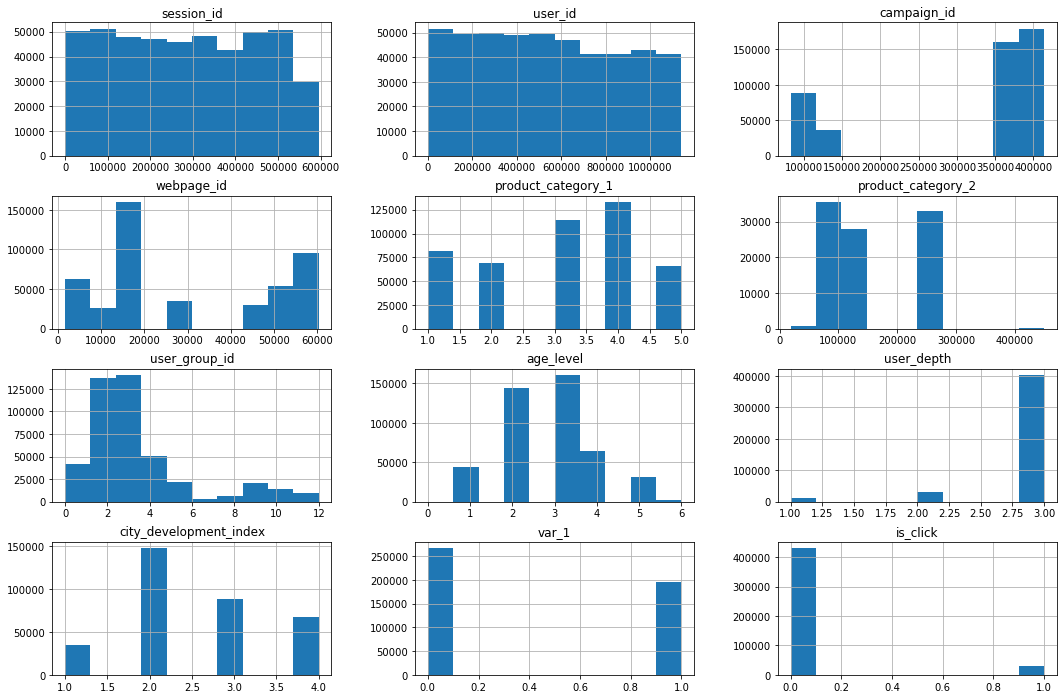

In [10]:
# histograms for non-object variables
fig = plt.figure(figsize = (18,12))
ax = fig.gca()
df.hist(ax=ax)
plt.show()

In [105]:
# number of unique values in all variables
list_ = []
for col in df:
    list_.append(df[col].nunique())

uniqueVal = pd.Series(data=list_, index= [df.columns])
print(uniqueVal)

session_id                445048
DateTime                    8604
user_id                   143837
product                       10
campaign_id                   10
webpage_id                     9
product_category_1             5
product_category_2            29
user_group_id                 13
gender                         2
age_level                      7
user_depth                     3
city_development_index         4
var_1                          2
is_click                       2
dtype: int64


In [108]:
# drop HCC
df.drop(columns= ['DateTime','user_id'], inplace= True)
# set session_id as index 
df.set_index('session_id', inplace=True)

In [109]:
# drop 'webpage_id' and 'campaign_id'
df.drop(columns= ['webpage_id','campaign_id'], inplace= True)

In [77]:
# a lot of missing values in product_category_2
# there appears to be same number of missing values in the user related features
df.isnull().sum()

session_id                     0
DateTime                       0
user_id                        0
product                        0
campaign_id                    0
webpage_id                     0
product_category_1             0
product_category_2        365854
user_group_id              18243
gender                     18243
age_level                  18243
user_depth                 18243
city_development_index    125129
var_1                          0
is_click                       0
dtype: int64

In [23]:
# drop missing values in user features since they account for a small portion of the dataset
df.dropna(subset= ['gender'], inplace= True)
df.isnull().sum()

product                        0
campaign_id                    0
webpage_id                     0
product_category_1             0
product_category_2        351379
user_group_id                  0
gender                         0
age_level                      0
user_depth                     0
city_development_index    106886
var_1                          0
is_click                       0
dtype: int64

In [24]:
# highly imbalanced target variable
df['is_click'].value_counts()

0    414991
1     30057
Name: is_click, dtype: int64

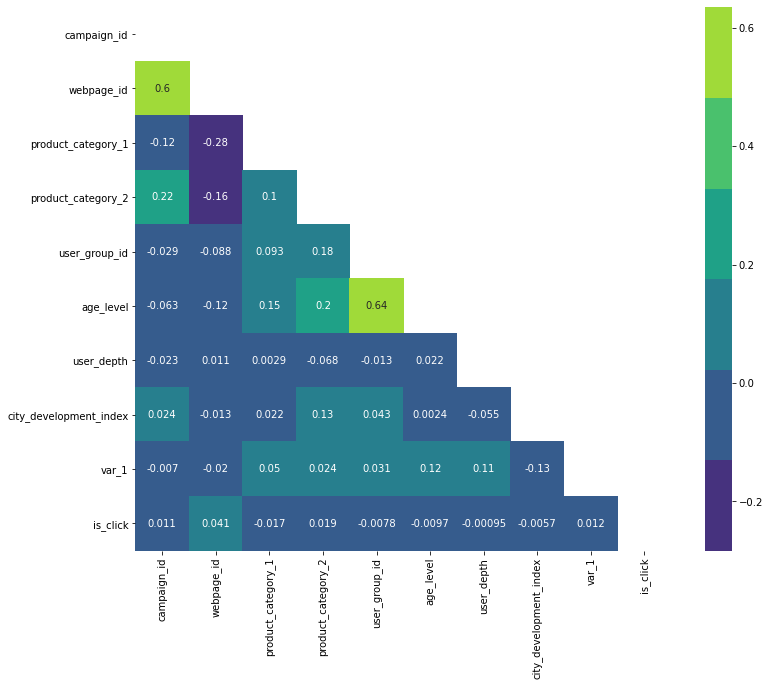

In [173]:
# lower triangle heatmap
# high corr pairs: webpage_id & campaign_id, age_level & user_group_id
corr = df.corr()
mask = np.triu(corr)
plt.figure(figsize=(12,10))
ax = sns.heatmap(corr, annot= True, mask=mask, cmap= sns.color_palette("viridis"))

# Balance Target Categories

In [25]:
# split train val sets
train, val = train_test_split(df, test_size=0.2, random_state=42)

# divide training set into minority and majority sets
df_minority = train[train['is_click']==1]
df_majority = train[train['is_click']==0]
df_majority['is_click'].value_counts()

0    332001
Name: is_click, dtype: int64

In [26]:
# up-sample minority set
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=332001,
    random_state=42
)

df_upsampled = pd.concat([df_minority_upsampled, df_majority])
df_upsampled['is_click'].value_counts()

0    332001
1    332001
Name: is_click, dtype: int64

# Modeling

In [27]:
# create feature matrix and target label
target = 'is_click'
X_train = df_upsampled.drop(columns= target)
y_train = df_upsampled['is_click']
X_val = val.drop(columns= target)
y_val = val['is_click']

In [28]:
# baseline accuracy
print('baseline accuracy ',df_upsampled[target].value_counts(normalize=True).max())

baseline accuracy  0.5


In [72]:
# logistic regression model
from sklearn.linear_model import LogisticRegression
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),    # Encode categorical values
    SimpleImputer(strategy='mean'),       # Fill Nan values with column mean 
    StandardScaler(),                     # Re-scale all features (mean = 0, std =1)
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['product', 'gender'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [73]:
# logistic regression model performance
print('training accuracy ',model_lr.score(X_train,y_train))
print('testing accuracy ', model_lr.score(X_val,y_val))
print(classification_report(y_val, model_lr.predict(X_val)))

training accuracy  0.5364712756889286
testing accuracy  0.5081563869228176
              precision    recall  f1-score   support

           0       0.94      0.50      0.66     82990
           1       0.08      0.57      0.14      6020

    accuracy                           0.51     89010
   macro avg       0.51      0.54      0.40     89010
weighted avg       0.88      0.51      0.62     89010



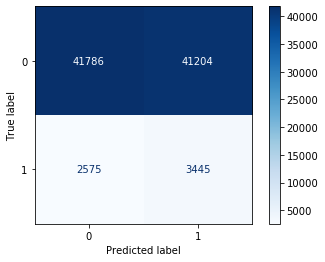

In [112]:
# plot confusion matrix for linear model
plot_confusion_matrix(model_lr, X_val, y_val, cmap=plt.cm.Blues)

In [102]:
# random forest model 
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'mean'),
    RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators= 100, max_depth= 19, max_samples= .6)
)

model_rf.fit(X_train_, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['product'],
                                mapping=[{'col': 'product',
                                          'data_type': dtype('O'),
                                          'mapping': C       1
H       2
D       3
F       4
I       5
B       6
J       7
E       8
G       9
A      10
NaN    -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=19, max_samples=0.6,
                                        n_jobs=-1, random_state=42))])

In [106]:
# random forest model performance
print('training accuracy ',model_rf.score(X_train_,y_train))
print('testing accuracy ', model_rf.score(X_val_,y_val))
print(classification_report(y_val, model_rf.predict(X_val_)))

training accuracy  0.5506715341218852
testing accuracy  0.5204583754634311
              precision    recall  f1-score   support

           0       0.95      0.52      0.67     82990
           1       0.08      0.59      0.14      6020

    accuracy                           0.52     89010
   macro avg       0.51      0.55      0.40     89010
weighted avg       0.89      0.52      0.63     89010



In [ ]:
# tuning hyperparameters for random forest model
clf = make_pipeline(OrdinalEncoder(),
                   SimpleImputer(),
                   RandomForestClassifier(random_state=42, n_jobs = -1))

param_grid = {'simpleimputer__strategy':['median','mean'],
             'randomforestclassifier__max_depth':range(5,20,2), 
             'randomforestclassifier__n_estimators':range(50,150,50),
             'randomforestclassifier__max_samples':np.arange(0.2, 1, 0.2)
              } 

model_rfrs = RandomizedSearchCV(clf, 
                               param_distributions = param_grid,
                               n_iter = 25,
                               cv = 5,
                               n_jobs = -1,
                               verbose = 10)
model_rfrs.fit(X_train,y_train)

In [ ]:
# retrieve best hyperparameters 
best_score = model_rfrs.best_score_
best_params = model_rfrs.best_params_
print(best_score, best_params)
# feed back into model using cell from above

In [ ]:
# XGBoost model
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'mean'),
    XGBClassifier(random_state = 42, n_jobs = -1)
)

model_xgb.fit(X_train, y_train)

In [ ]:
# XGBoost model performance
print('training accuracy ',model_xgb.score(X_train,y_train))
print('testing accuracy ', model_xgb.score(X_val,y_val))
print(classification_report(y_val, model_xgb.predict(X_val)))

In [ ]:
# tuning hyperparameters for XGBoost model
clf = make_pipeline(OrdinalEncoder(),
                   SimpleImputer(),
                   XGBClassifier(random_state=42, n_jobs = -1))

param_grid = {'simpleimputer__strategy':['median','mean'],
             'xgbclassifier__max_depth':range(5,20,2), 
             'xgbclassifier__n_estimators':range(50,150,50),
             'xgbclassifier__learning_rate':[0.01, 0.1, 0.2, 0.4, 1]
              } 

model_xgbrs = RandomizedSearchCV(clf, 
                               param_distributions = param_grid,
                               n_iter = 25,
                               cv = 5,
                               n_jobs = -1,
                               verbose = 10)
model_xgbrs.fit(X_train,y_train)

In [ ]:
# retrieve best hyperparamters 
best_score = model_xgbrs.best_score_
best_params = model_xgbrs.best_params_
print(best_score, best_params)
# feed back into model using cell from above

Text(0.5, 0, 'Chi Values')

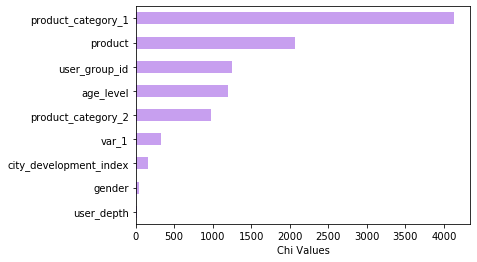

In [95]:
# going back to feature selection
# calculate chi-square values of feature variables 
from scipy.stats import chi2_contingency
list = []
for col in X_train.columns:
    list.append(chi2_contingency(pd.crosstab(X_train[col], y_train))[0])

chiValue = pd.Series(list, index=X_train.columns).sort_values()
chiValue.plot(kind='barh',color='xkcd:lavender')
plt.xlabel('Chi Values')

In [91]:
# drop feature variables with three lowest chi-square values: 'city_development_index','gender', and 'user_depth'
df = pd.read_csv('Ad_click_prediction_train.csv')
df.set_index('session_id', inplace=True)
df.drop(columns=['DateTime','user_id','webpage_id','campaign_id','city_development_index','gender','user_depth'],inplace=True)
df.info()
# rerun all other preprocessing cells from above and model again

None
